<a href="https://colab.research.google.com/github/DhafinRA/ML-Upatik/blob/main/Food_Classification_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [17]:
#HYPERPARAMETER

EPOCHS = 3
LOSS = tf.keras.losses.CategoricalCrossentropy()
OPTIMIZERS = tf.keras.optimizers.Adam()
input_shape = (224,224,3)

In [18]:
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
#                                                             horizontal_flip=True,
#                                                             vertical_flip=True,
#                                                             rotation_range=60,
#                                                             width_shift_range=0.8,
#                                                             height_shift_range=0.8,)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                rotation_range=40,
                                                                height_shift_range=0.2,
                                                                width_shift_range=0.2,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                fill_mode='nearest')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

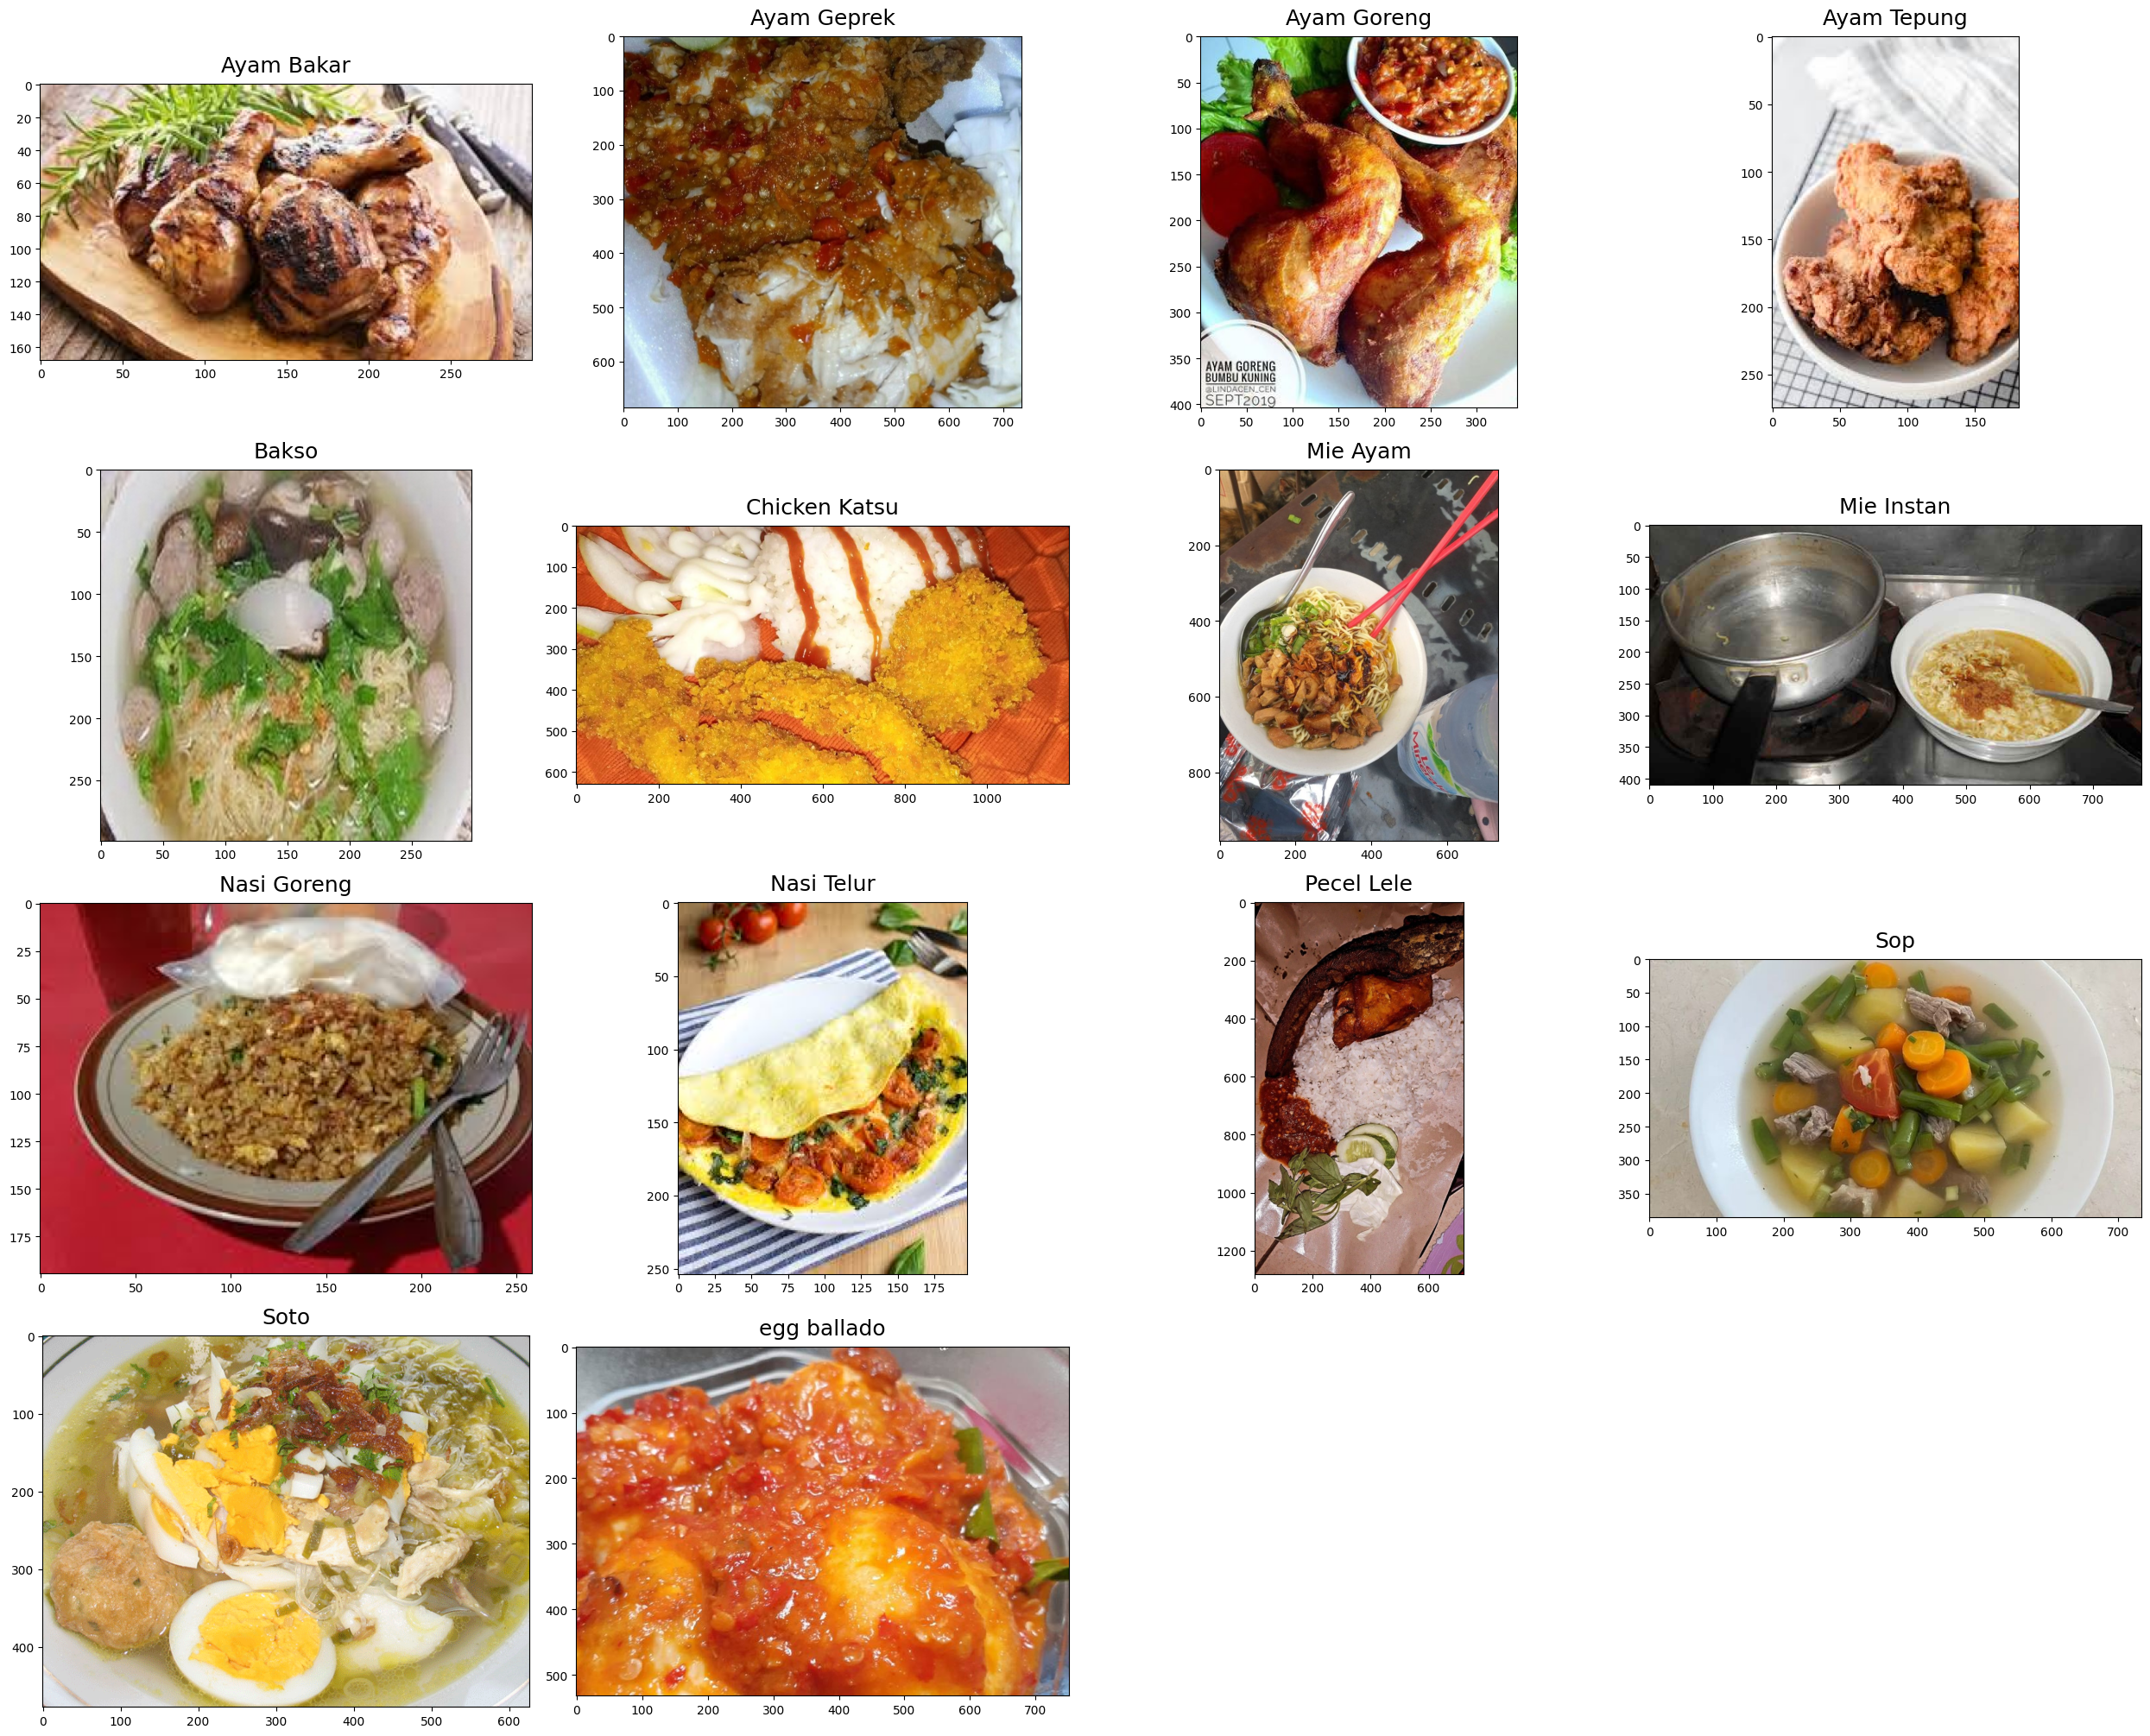

In [19]:
train_dir = "Dataset\Train"
test_dir = "Dataset\Test"
images = []
labels = []

for food_folder in sorted(os.listdir(train_dir)):
    food_items = os.listdir(train_dir + '/' + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_dir,food_folder,food_selected))

fig=plt.figure(1, figsize=(25, 25))

for subplot,image_ in enumerate(images):
    category=image_.split('\\')[-2]
    imgs = plt.imread(image_)
    a,b,c=imgs.shape
    fig=plt.subplot(5, 4, subplot+1)
    fig.set_title(category, pad = 10,size=18)
    plt.imshow(imgs)
    labels.append(category)

plt.tight_layout()

In [20]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=10,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(224, 224),
                                                    batch_size=2,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

Found 2673 images belonging to 14 classes.
Found 907 images belonging to 14 classes.


In [83]:
# class myCallback(tf.keras.callbacks.Callback):
#         def on_epoch_end(self, epoch, logs={}):
#             if (logs.get('val_accuracy') > 0.83 and logs.get('accuracy')>0.83):
#                 print('\naccuracy and validation accuracy reached 83%,so cancelling training!')
#                 self.model.stop_training = True
                
# callbacks = myCallback()

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Model/model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    restore_best_weights = True,
    patience=2
)

In [100]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,kernel_size=3,activation='relu',input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(14,activation='softmax')
])

model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_84 (MaxPooli  (None, 111, 111, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_85 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_85 (MaxPooli  (None, 54, 54, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_86 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_86 (MaxPooli  (None, 26, 26, 64)      

In [103]:
# model.load_weights('Weights/weight')
model.compile(loss='CategoricalCrossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(train_generator,epochs=50,validation_data=test_generator,callbacks=[model_checkpoint_callback])

Epoch 1/50
  7/268 [..............................] - ETA: 1:33 - loss: 0.5664 - accuracy: 0.8000

KeyboardInterrupt: 

In [32]:
model.save_weights('Weights/weight')

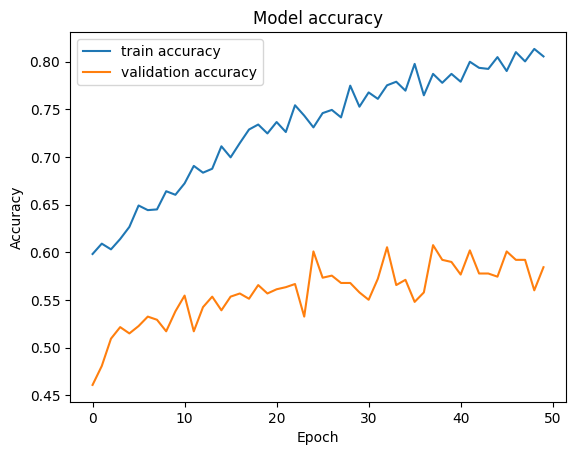

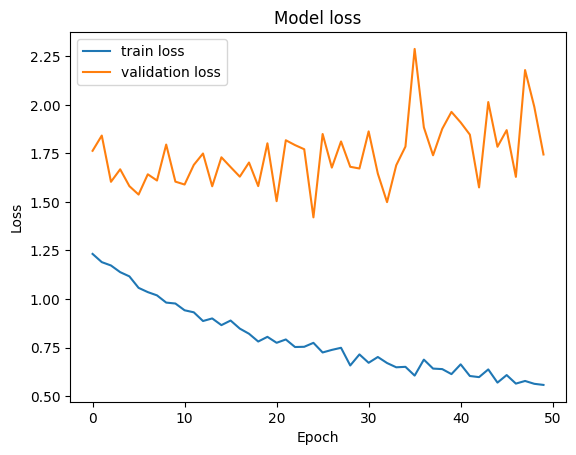

In [33]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

plot_accuracy(history)
plot_loss(history)

In [25]:
base_model = tf.keras.applications.MobileNetV3Large(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

# base_model.summary()

In [26]:
# full_model = tf.keras.Sequential([
#     base_model.output,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(256,activation='relu'),
#     tf.keras.layers.Dense(14,activation='softmax')
# ])

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

predictions = tf.keras.layers.Dense(14,activation='softmax')(x)

full_model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

In [27]:
full_model.compile(loss=LOSS,optimizer=OPTIMIZERS,metrics=['accuracy'])
full_model.fit(train_generator,epochs=EPOCHS,validation_data=test_generator)

Epoch 1/3
268/268 [==============================] - 273s 938ms/step - loss: 1.4610 - accuracy: 0.5436 - val_loss: 3.8068 - val_accuracy: 0.0772
Epoch 2/3
 41/268 [===>..........................] - ETA: 3:12 - loss: 0.8282 - accuracy: 0.7537

KeyboardInterrupt: 

In [ ]:
def load_image(img_path, show=False):

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224,3))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [ ]:
img_path = 'Dataset/Test/Mie Instan/mie81.jpg'
new_image = load_image(img_path,show=True)

pred = model.predict(new_image)
result = np.argmax(pred)
print(labels[result])
